# Code to optimize W TES around 1064nm

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt

In [3]:
import admittance

In [4]:
from optimize import layers2t, build_gui, gui2layers

In [33]:
admittance.nk.keys()

dict_keys(['air', 'SiN_sellmeier', 'Ti_ebeam_old', 'Ti_nk', 'Al_Palik', 'Ag_Palik', 'Au_Macleod', 'aSi_ingot', 'aSi_JAWoollam', 'W_AJA', 'W_JAWoollam', 'W_trilayer_L_2019', 'W_trilayer_C_2019', 'SiO2_Macleod', 'SiO2_ECR', 'Hf_Quartz', 'TiA1_Quartz', 'Bi', 'Bi_thin', 'Bi_film', 'Bi_film_extrapolated', 'Mo', '1_33', 'TaOx', 'Silicon', 'aSi_AJA_2nm', 'aSi_AJA_Filmetrics', 'aSi_Metricon', 'SiO2_Metricon', 'SiO2_ECR_Filmetrics', 'aSi_190312', 'W_190321', 'W_trilayer_29'])

## build gui to edit intial values and pick which layers will vary

In [5]:
stack_description=['air', 
                   'SiN_sellmeier',
                   'SiO2_Metricon',
                   'aSi_190312',
                   'W_trilayer_29',
                   'aSi_Metricon',
                   'SiN_sellmeier',
                   'Au_Palik',
                   'air'
                  ]
initial_guess = [np.inf,
              140.95,
              36.26,
              2,
              20,
              2,
              69.62,
              20,
             np.inf]



stack_gui = build_gui(stack_description, initial_guess)

In [6]:
stack_gui

### Build lmfit parameters that will be used to do the optimizations

In [10]:
layers = gui2layers(stack_gui)
layers

name,value,initial value,min,max,vary
layer0,inf,inf,1.00000000,inf,False
layer1,100.000000,100.0,0.00000000,1000.00000,True
layer2,36.2600000,36.26,0.00000000,1000.00000,True
layer3,2.00000000,2.0,0.00000000,1000.00000,False
layer4,20.0000000,20.0,1.00000000,1000.00000,True
layer5,2.00000000,2.0,0.00000000,1000.00000,False
layer6,69.6200000,69.62,0.00000000,1000.00000,True
layer7,20.0000000,20.0,0.00000000,1000.00000,False
layer8,inf,inf,1.00000000,inf,False


In [11]:
temp = []
for key in layers.keys():
    temp.append(layers[key].user_data['name'])
temp

['air',
 'SiN_sellmeier',
 'SiO2_Metricon',
 'aSi_190312',
 'W_trilayer_29',
 'aSi_Metricon',
 'SiN_sellmeier',
 'Au_Palik',
 'air']

In [26]:
def optimize_W_a(layers):
    t = []
    stack = []
    for key in layers.keys():
        t.append(layers[key].value)
        stack.append(layers[key].user_data['name'])
    wl = 1064 + np.arange(-100, 101, 10)
    #wl = np.arange(630, 1800, 50)
    r = admittance.stack_v2(stack, t, wl)
    w_idx = 4
    
    #error = ((1-1/r['RAT'][:,w_idx])**2).sum() # + (r['RAT'][:,0]**2).sum() + (r['RAT'][:,-1]**2).sum()
    #error = np.abs((1-1/r['RAT'][:,w_idx])).sum() 
    error = (1-r['RAT'][:,w_idx]).sum() #  
    #error = (r['RAT'][:,0]**2).sum() + (r['RAT'][:,-1]**2).sum()
    return error


In [27]:
optimize_W_a(layers)

4.204939081103762

In [28]:
results = lmfit.minimize(optimize_W_a, layers, method='dual_annealing')
optimize_W_a(results.params), layers2t(results.params)

(0.5797629080262963,
 [inf,
  108.87039746494415,
  0.0,
  2.0,
  22.14962828266348,
  2.0,
  127.94475343742788,
  20.0,
  inf])

In [29]:
results = lmfit.minimize(optimize_W_a, layers, method='ampgo')
optimize_W_a(results.params), layers2t(results.params)

(0.5797629066870509,
 [inf,
  108.87388270819132,
  5.81401593535702e-09,
  2.0,
  22.150099326135617,
  2.0,
  127.94855695075103,
  20.0,
  inf])

In [30]:
results = lmfit.minimize(optimize_W_a, layers, method='tnc')
optimize_W_a(layers), optimize_W_a(results.params), layers2t(results.params)

(4.204939081103762,
 0.5797631017631134,
 [inf,
  108.88507190544483,
  2.279300248542171e-06,
  2.0,
  22.154767491127853,
  2.0,
  127.98076862076712,
  20.0,
  inf])

In [31]:
results = lmfit.minimize(optimize_W_a, layers, method='nelder')
optimize_W_a(layers), optimize_W_a(results.params), layers2t(results.params)

(4.204939081103762,
 0.5797629134194033,
 [inf,
  108.87338895115239,
  1.6284166237667819e-06,
  2.0,
  22.150453758494965,
  2.0,
  127.95236920420538,
  20.0,
  inf])

<IPython.core.display.Javascript object>


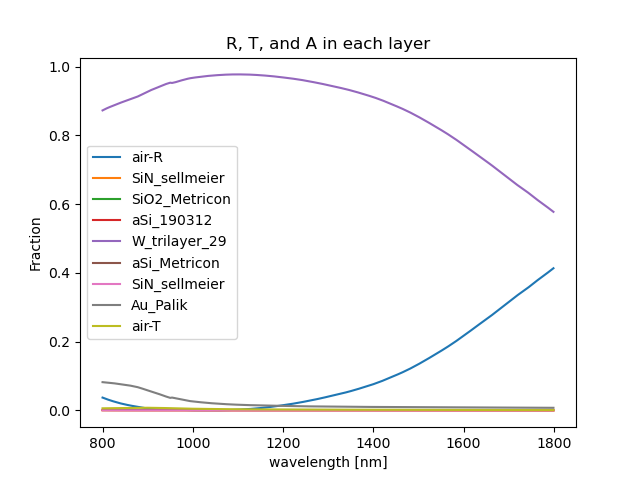

Text(0, 0.5, 'Fraction')

In [32]:
%matplotlib notebook
plt.figure()
wl = np.arange(800, 1800)
r = admittance.stack_v2(stack_description, layers2t(results.params), wl)
import matplotlib.pyplot as plt
for idx in range(r['RAT'].shape[1]):
    text = layers[f'layer{idx}'].user_data['name']
    # mark labels which have the R and T values
    if idx==0:
        text += "-R"
    if idx == r['RAT'].shape[1]-1:
        text += "-T"
    y = r['RAT'][:,idx]
    #if idx == 4:
    #    y = 1-y
    plt.plot(wl, y, label=text)

plt.legend()
plt.title('R, T, and A in each layer')
plt.xlabel('wavelength [nm]')
plt.ylabel('Fraction')
#plt.axis([1000, 1200, 0.5, 1])

In [ ]:
for name in stack_description:
    print(name, admittance.nk[name].min, admittance.nk[name].max)